# CNN 
Prevedere 3 problemi su A-E vs A-P, A-E vs I-E e A-E vs A-P vs BG

In [3]:
import nbimporter
from Import_data import get_df_class, get_df_epigenomic, get_df_sequence , get_type_of_nucl_from_list_of_sequence, convertToNum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical 
sns.set(color_codes=True)

%matplotlib inline

ImportError: cannot import name 'get_df_class'

In [ ]:
problem = [['A-E','A-P'],['A-E','I-E'],]

In [2]:
path_c = '../data/classes/GM12878.csv'
path_e = '../data/epigenomic-data/GM12878.csv'
path_s = '../data/sequences/GM12878.fa'

df_c = get_df_class(path_c)
df_e = get_df_epigenomic(path_e)
df_s = get_df_sequence(path_s)

NameError: name 'get_df_class' is not defined

In [8]:
df_s.head()

id                                                seq
0  chr1:1136806-1137006  GCCCGGGAGGAGCCGGAGACTCCGGAGACCCCGCCCAGAGCCCGCT...
1  chr1:1840542-1840742  ACCGCCCCGAGTCCGCGCGGCCTGCGAGCGCCGTCTGGTGGGAAAG...
2  chr1:2231838-2232038  GGGTCACACCAGAGGCAAGCGGTCGTAGCTGCTCTTCCCAGAGTAA...
3  chr1:2232562-2232762  CCCAGCCGGGCGTCCTCGGCCTTCTGTGCCTCTCGGGAGGGTCCGC...
4  chr1:2478446-2478646  CAGGGCGGGGCGTGGGCTGAGCAGCCCCTCCCATGGAGGGAGCGGC...

In [9]:
type_of_nucl = get_type_of_nucl_from_list_of_sequence(df_s['seq'])
type_of_nucl

['A', 'C', 'G', 'N', 'T']

In [10]:
nucl2int = convertToNum(type_of_nucl)

In [11]:
seq =  to_categorical(np.asarray([ [ nucl2int(el1) for el1 in el ] for el in df_s['seq'].values ]), num_classes=len(type_of_nucl), dtype="int8")
seq.shape

(223049, 200, 5)

In [12]:
# conversione etichette one_hot (si potrebbe fare anche singolo)
type_of_class = sorted(list(df_c['class'].unique()))
lab2int = convertToNum(type_of_class)
classes = np.asarray([  lab2int(el) for el in df_c["class"].values])
print(type_of_class)
classes

['A-E', 'A-P', 'A-X', 'I-E', 'I-P', 'I-X', 'UK']


array([0, 0, 0, ..., 6, 6, 6])

In [13]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D,Conv2D, MaxPooling2D
from keras import losses
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

/home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [14]:
int_labels = [lab2int(el) for el in problem[0]]
int_labels, problem[0]

([0, 1], ['A-E', 'A-P'])

In [15]:
n_split = 2
random_state = 42
X = seq
y = classes
mask = [ el in int_labels for el in classes ]
X,y = X[mask],y[mask]
set(y), len(y)

({0, 1}, 13694)

In [16]:
np.bincount(y)

array([ 2878, 10816])

In [17]:

randSampler = RandomOverSampler(random_state=random_state)

def resampler(x,y):
    # https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
    nsamples, nx, ny = x.shape
    d2_train_dataset = x.reshape((nsamples,nx*ny))
    d2_train_dataset.shape

    # bilanciamo solo il training
    x, y = randSampler.fit_resample(d2_train_dataset, y)
    
    nsamples , elems = x.shape
    x = x.reshape((nsamples, nx, ny))
    
    return x,y


In [19]:
#1D kernel 
batch_size = 16
epochs = 12
input_shape = X[0].shape
model = Sequential()

model.add(Conv1D(64, kernel_size=5,strides=1,
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv1D(128,kernel_size=3, activation='relu'))
model.add(Dropout(0.75))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

plot_model(model, to_file='model.png',show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
skf = StratifiedKFold(n_splits=n_split)

confMatr = []
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_balanced, y_train_balanced = resampler(X_train, y_train)
    print(f'{np.bincount(y_train_balanced)}')
    print( X_train_balanced.shape ,len(y_train_balanced))
    model.fit(X_train_balanced, y_train_balanced,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:\n', score[1])
    y_pred=model.predict(X_test)
    y_pred =(y_pred>0.5)
    cm = confusion_matrix(y_test, y_pred)
    confMatr.append(cm)
    

[5408 5408]
(10816, 200, 5) 10816
Instructions for updating:
Use tf.cast instead.
Train on 10816 samples, validate on 6847 samples
Epoch 1/12
  928/10816 [=>............................] - ETA: 1:06 - loss: 0.6508 - acc: 0.6412

KeyboardInterrupt: 

In [64]:
g = 3
fig  = plt.figure()
for el in range(g):
    ax = fig.add_subplot(2,2,el)
    



[array([[ 638,   82],
        [ 247, 2457]]), array([[ 654,   66],
        [ 186, 2518]]), array([[ 678,   41],
        [ 191, 2513]]), array([[ 693,   26],
        [ 278, 2426]])]

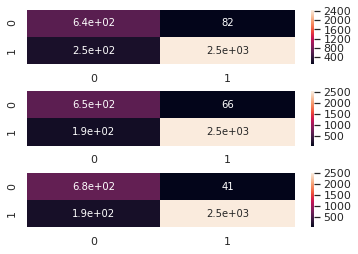

In [67]:
fig, axes = plt.subplots(nrows=n_split, ncols=1)
#fig.subplots_adjust(hspace=0.5)

for ax, conf in zip(axes.flatten(), confMatr):
    sns.heatmap(conf,annot=True, ax=ax)
    #ax.set(title=name[:-4].upper(), xlabel='cm')